# Population estimation

## 1. The challenge: Helmholtz AI CountMeIn

## 2. The data
**Population data**: The European Statistical System (ESSnet) project, in co-operation with the European Forum for Geography and Statistics (EFGS), produced the high resolution (1km) population grids from the population census in Europe. We processed this freely available population grids for each city. 

**Sentinel-2 (SEN2)**: Processed only the RGB bands at 10 m resolution for all four seasonal sets (spring, summer, autumn and winter) of Sentinel-2 images to capture the seasonal variation in the data.

**Local climate zones (LCZ)**: Processed the urban local climate zone classifications, So2Sat LCZ v1.0, produced by fusing the freely available satellite data from Sentinel-1 and Sentinel-2 satellites using deep learning.

**Nighttime lights (VIIRS)**: Processed the freely available cloud free annual composites of global VIIRS nighttime lights.

**Land use classification (LU)**: Mapped OSM tags to a simplified land use classification scheme: commercial, industrial, residential, and other that results in a four band raster with corresponding land use proportions.

In [1]:
# install the required packages
import sys
# !{sys.executable} -m pip install -r requirements.txt

In [2]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf

In [3]:
# this should match the name of the data sets
filename_train = 'data/train_countmein.h5'
filename_test = 'data/test_countmein.h5'

dataset_train = h5py.File(filename_train, 'r')
dataset_test = h5py.File(filename_test, 'r')

# show the content names
print(list(dataset_train.keys()))

['lcz', 'lu', 'population', 'sentinel2_autumn', 'sentinel2_spring', 'sentinel2_summer', 'sentinel2_winter', 'viirs']


In [4]:
pop_train = np.array(dataset_train['population'])

# show the shape
print("Population train data shape: ", pop_train.shape)

# print the ground truth for one sample
print("This is how the ground truth for one sample looks like:", pop_train[100,:])

# note that it is a pair (class, population count), thus we store just one part
pop_count_train = pop_train[:,1]

pop_test = np.array(dataset_test['population'])
pop_count_test = pop_test[:,1]

Population train data shape:  (267, 2)
This is how the ground truth for one sample looks like: [ 7 99]


Sentinel-2 shape:  (267, 100, 100, 3)


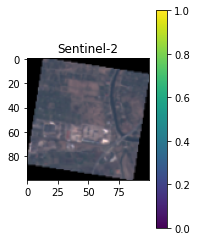

In [5]:
# load Sentinel-2 data (Spring snapshots)
sen2_spring_train = np.array(dataset_train['sentinel2_spring'])
sen2_spring_test = np.array(dataset_test['sentinel2_spring'])

print("Sentinel-2 shape: ", sen2_spring_train.shape)
# 267, 100x100 pixels, 3 channels samples

def norm_img(X):        
    return ((X - np.min(X)) / (np.max(X) - np.min(X)))
    

index = 119
plt.subplot(122)
plt.imshow(norm_img(sen2_spring_train[index,:]))
plt.colorbar()
plt.title('Sentinel-2')
plt.show()

VIIRS shape:  (267, 100, 100, 1)


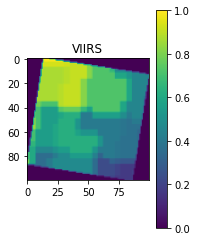

In [6]:
# load VIIRS
viirs_train = np.array(dataset_train['viirs'])

print("VIIRS shape: ", viirs_train.shape)
# 267, 100x100 pixels, 3 channels samples

def norm_img(X):        
    return ((X - np.min(X)) / (np.max(X) - np.min(X)))
    
plt.subplot(122)
plt.imshow(norm_img(viirs_train[index,:]))
plt.colorbar()
plt.title('VIIRS')
plt.show()

## 3. Random forest regressor


In [7]:
# Random forest regressor needs a vector as input
_shape = sen2_spring_train.shape
X_train = np.reshape(sen2_spring_train, (_shape[0], _shape[1] * _shape[2] * _shape[3]))
print("X train shape:", X_train.shape)

_shape = sen2_spring_test.shape
X_test = np.reshape(sen2_spring_test, (_shape[0], _shape[1] * _shape[2] * _shape[3]))
print("X test shape:", X_test.shape)

X train shape: (267, 30000)
X test shape: (324, 30000)


In [ ]:
rf_base = RandomForestRegressor(random_state=3108)

rf_base.fit(X_train, pop_count_train)

In [99]:
pop_pred_rf = rf_base.predict(X_test)

In [ ]:
mae_base = mean_absolute_error(pop_count_test, pop_pred_rf)
rmse_base = mean_squared_error(pop_count_test, pop_pred_rf, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_base = r2_score(pop_count_test, pop_pred_rf)

print("MAE:", mae_base) # Best possible is 0
print("RMSE:", rmse_base) # Best possible is 0
print("R2:", r2_base) # Best possible is 1

Total population in test set: 379191
Total population predicted: 935716.85
Average population per sample in test set: 1170.3425925925926


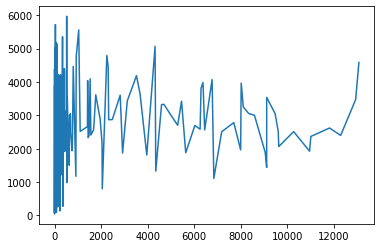

In [111]:
print("Total population in test set:", np.sum(pop_count_test))
print("Total population predicted:", np.sum(pop_pred_rf))

print("Average population per sample in test set:", np.average(pop_count_test))
plt.plot(pop_count_test, pop_pred_rf)